In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
from tensorflow.keras.models import load_model
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa
from datetime import datetime
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from pesq import pesq
import pystoi
import pandas as pd

from utils import calculate_snr, itakura_distortion, somar_sinais, add_white_gaussian_noise, performance, calculate_stft_magnitude_and_phase, reconstruct_signal_from_stft
from data_generators import NoisyTargetWithMetricsGenerator
from sound import Sound
import tensorflow.keras.backend as K

In [3]:
from artigos.PRIDNet import Convolutional_block, Channel_attention, AttResUnetConvLSTM, Avg_pool_Unet_Upsample_msfe, Multi_scale_feature_extraction, Kernel_selecting_module
from keras.utils import custom_object_scope

In [4]:
base_shape_size = 8192
ws = 255
ol = 128

In [5]:
sound_base = Sound('/tf/Dados/Vozes/test/', '/tf/Dados/Ruido/test/', base_shape_size)

Loading Speech Files: 100%|██████████| 819/819 [00:01<00:00, 506.35it/s]
/tf/utils/sound.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  clean_sounds = [sound for sound in clean_sounds if sound != self.TOO_SHORT_ERROR]
/tf/utils/sound.py:74: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  noise_sounds = [sound for sound in noise_sounds if sound != self.TOO_SHORT_ERROR]


In [6]:
def stft_to_signal(stft, sampling_rate=8000, window_size=ws, overlap=ol):
    A = stft[..., 0]
    phi = stft[..., 1]
    signal = reconstruct_signal_from_stft(A, phi, sampling_rate=sampling_rate, window_size=window_size, overlap=overlap)

    return signal

In [7]:
data_generator = NoisyTargetWithMetricsGenerator(sound_base.clean_sounds, sound_base.noise_sounds)

In [12]:
def process_batch(x_batch, y_batch, model):

    # module = x_batch[:, :, :, 0].reshape(-1,128, 64, 1)
    # phase = x_batch[:, :, :, 1].reshape(-1,128, 64, 1)
    
    # stfts = model.predict(module, verbose=False)

    # stfts = np.concatenate((stfts, phase), axis=3)
    stfts = model.predict(x_batch, verbose=False)
    
    M, height, width, channels = stfts.shape  # Obtenha as dimensões do array de resultados do modelo

    pesq_scores = []
    stoi_scores = []
    snr_scores = []
    ID_scores = []

    for i in range(M):
        filtered = stfts[i, :, :, :]  # Obtenha o resultado do modelo para a iteração atual

        clean = y_batch[i, :, :, :]  # Obtenha o sinal limpo correspondente

        clean_signal = stft_to_signal(clean).reshape(-1)
        filtered_signal = stft_to_signal(filtered).reshape(-1)

        try:
            pesq_score = pesq(8000, clean_signal, filtered_signal, 'nb')
        except:
            pesq_score = 1.04
        stoi_score = pystoi.stoi(clean_signal, filtered_signal, 8000)
        snr_score = calculate_snr(clean_signal, filtered_signal)
        # ID_score = itakura_distortion(clean_signal, filtered_signal, 256, 11)

        pesq_scores.append(pesq_score)
        stoi_scores.append(stoi_score)
        snr_scores.append(snr_score)
        # ID_scores.append(ID_score)

    return pesq_scores, stoi_scores, snr_scores, ID_scores

In [13]:
batch_num = 50
df_resultado = pd.DataFrame()

In [14]:
# model = load_model('DNS-loss-0.0212-epochs-3-2023-11-11_21-09-11.h5')
with custom_object_scope({'Convolutional_block': Convolutional_block,
                          'Channel_attention': Channel_attention,
                          'AttResUnetConvLSTM': AttResUnetConvLSTM,
                          'Avg_pool_Unet_Upsample_msfe': Avg_pool_Unet_Upsample_msfe,
                          'Multi_scale_feature_extraction': Multi_scale_feature_extraction,
                          'Kernel_selecting_module': Kernel_selecting_module}):
    model = load_model('PRIDNet_loss-0.0165-epochs-54.h5')
    # model = load_model('best_PRIDNet_0.0031_epochs_92.h5')

In [15]:
results = []

for _ in tqdm(range(batch_num)):
    x_batch, y_batch, metrics_batch_df = next(data_generator.generate_sample_completo(batch_size=128))
    results.append((process_batch(x_batch, y_batch, model),metrics_batch_df))

df_resultado = pd.DataFrame()

for result , metrics_batch_df in results:
    pesq_scores, stoi_scores, snr_scores, ID_scores = result
    metrics_batch_df['PESQ (Filtered)'] = pesq_scores
    metrics_batch_df['STOI (Filtered)'] = stoi_scores
    metrics_batch_df['SNR (Filtered)'] = snr_scores
    # metrics_batch_df['ID (Filtered)'] = ID_scores
    
    df_resultado = pd.concat([df_resultado, metrics_batch_df], ignore_index=True)

100%|██████████| 50/50 [05:54<00:00,  7.09s/it]


In [16]:
df_resultado

,PESQ,STOI,SNR,PESQ (Filtered),STOI (Filtered),SNR (Filtered)
0,2.418011,0.944409,16.887169,4.004261,0.972245,16.684217
1,1.871436,0.882542,5.942153,3.195333,0.960920,11.993188
2,1.697418,0.856212,10.415987,2.736113,0.910535,10.589859
3,2.060054,0.930958,13.485483,3.436003,0.945548,10.405169
4,1.978267,0.877025,12.846158,3.647862,0.945277,15.787853
...,...,...,...,...,...,...
6392,1.313850,0.452521,0.428934,1.306552,0.499623,7.886850
6393,1.584124,0.268146,4.137088,1.599564,0.292463,7.690113
6394,1.724604,0.753685,10.574474,2.960447,0.754913,9.602159
6395,3.186211,0.972716,17.995312,3.926147,0.971082,13.078426


In [17]:
df_resultado.describe()

,PESQ,STOI,SNR,PESQ (Filtered),STOI (Filtered),SNR (Filtered)
count,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000
mean,2.131877,0.846744,9.343268,3.437304,0.907674,13.238897
std,0.564428,0.133174,5.651769,0.574552,0.095912,3.665579
min,1.046566,0.054887,-0.101471,1.040000,0.068806,-0.865156
25%,1.702083,0.781093,4.843597,3.075130,0.882402,10.281779
50%,2.061113,0.885673,9.638408,3.553182,0.940307,12.974254
75%,2.475013,0.947965,14.004372,3.890431,0.969478,16.111627
max,4.411059,0.998559,29.019289,4.387761,0.996687,23.232362


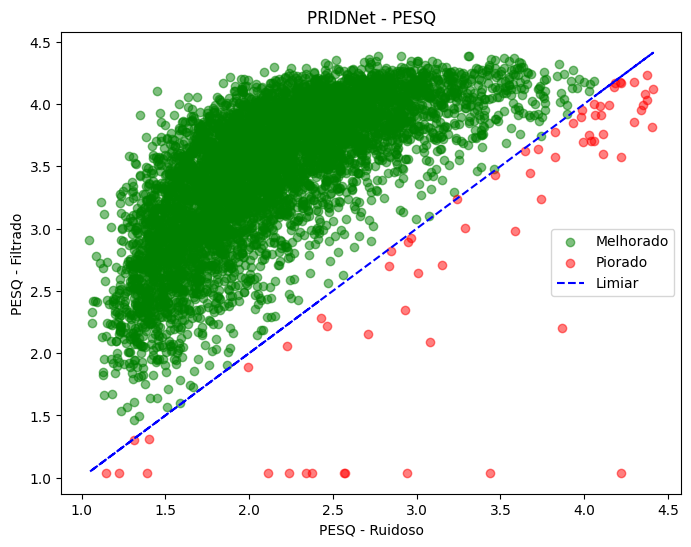

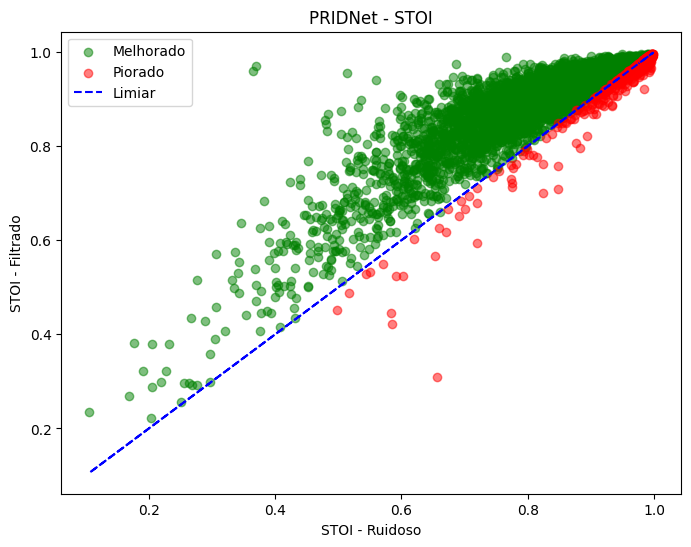

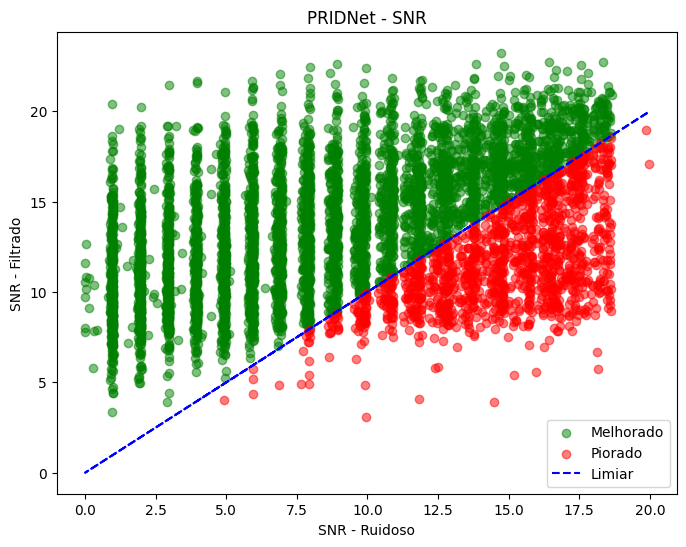

In [20]:
performance(df_resultado, 'PRIDNet', snr_lte=20.)

In [21]:
# Get the current datetime
current_datetime = datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Define the file name with the datetime
file_name = f"PRIDNet-metrics-0.0165_{datetime_str}.xlsx"

In [22]:
df_resultado.to_excel(file_name, index=False)